In [ ]:
!pip install opendatasets --quiet

In [ ]:
# по API подключаемся к kaggle и скачиваем нужный датасет
# для этого в colab надо подгрузить файл kaggle.json, который содержит токен и пароль
# после этого в проводнике colab появится папка с данными
import opendatasets as od
import pandas as pd

od.download( "https://www.kaggle.com/competitions/automated-video-captioning")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adele1997
Your Kaggle Key: ··········


100%|██████████| 1.08G/1.08G [00:11<00:00, 105MB/s]



Extracting archive ./automated-video-captioning/automated-video-captioning.zip to ./automated-video-captioning


In [ ]:
import pandas as pd
import os

train_df = pd.read_csv('/content/automated-video-captioning/train.csv')
test_df = pd.read_csv('/content/automated-video-captioning/train.csv')

train_video_path = '/content/automated-video-captioning/train_videos'
test_video_path = '/content/automated-video-captioning/test_videos'

print(train_df.shape)
print(len(os.listdir(train_video_path)))

print(test_df.shape)
print(len(os.listdir(test_video_path)))

(603, 3)
603
(603, 3)
521


In [ ]:
train_df.head()

,index,file_name,caption
0,0,0.mp4,A man is working out on a seated chest press m...
1,1,1.mp4,Preparing a bowl with yogurt and assorted fres...
2,2,2.mp4,A man with a muscular build is seen from behin...
3,3,3.mp4,Man exercising by jogging on a pedestrian brid...
4,4,4.mp4,Wristwatch hands moving forward close-up views.


In [ ]:
train_df.loc[0, 'caption']

'A man is working out on a seated chest press machine in a modern gym. He is focused and wearing a black sleeveless shirt and shorts. The gym has bright overhead lighting and various equipment in the background.'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# from PIL import Image
import cv2

import pandas as pd
import random

import nltk
# pymorphy
from nltk.tokenize import word_tokenize

from collections import Counter
import numpy as np

# ========== Параметры ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LEN = 20   # макс длина caption
NUM_FRAMES = 11    # кадров с видео
BATCH_SIZE = 8
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_EPOCHS = 10
IMG_SIZE=(224, 224)
LR = 1e-3

In [ ]:
# =======================
# 1. Вспомогательные функции
# =======================

# def extract_frames(video_path, num_frames=NUM_FRAMES):

def extract_frames(path, img_size, transform=None, frames_num=11):
    frames = []
    cap = cv2.VideoCapture(path)

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, length-1, frames_num).astype(int)

    for frame_id in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, img_size)
        if transform:
            frame = transform(Image.fromarray(frame))
        else:
            frame = Image.fromarray(frame)
        frames.append(frame)

    cap.release()

    # Если кадров меньше, дублируем последний
    while len(frames) < frames_num:
        frames.append(frames[-1])
    return frames

In [ ]:
one_video_path = '/content/automated-video-captioning/train_videos/0.mp4'
one_video_frames = extract_frames(one_video_path, IMG_SIZE)

len(one_video_frames)

11

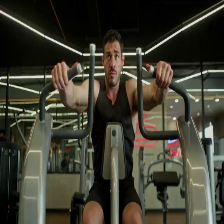

In [ ]:
one_video_frames[0]

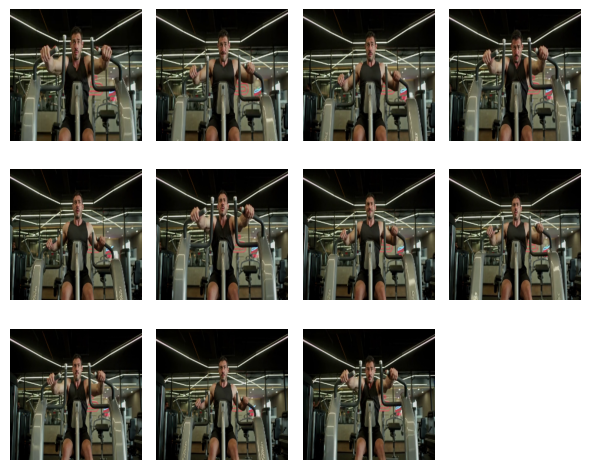

In [ ]:
import matplotlib.pyplot as plt

n = len(one_video_frames)
cols = 4  # Кол-во колонок в гриде
rows = (n + cols - 1) // cols  # Вычисляем нужное кол-во строк

plt.figure(figsize=(6, 5))
for i, img in enumerate(one_video_frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# =======================
# 2. Токенизация и словарь
# =======================

class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}

    # <PAD> - padding
    # <SOS> - Start of sequence
    # <EOS> - End of sequence
    # <UNK> - unknown - не известное значение
    def __len__(self):
        return len(self.itos)

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            # токен - это минимальная ед. изм. текста
            for word in word_tokenize(sentence.lower()):
                frequencies[word] += 1

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

In [ ]:
# =======================
# 3. Dataset
# =======================

# Dataset - torch
class VideoCaptionDataset(Dataset):
    def __init__(self, df, video_dir, vocab, img_size = IMG_SIZE, transform=None, max_seq_len=MAX_SEQ_LEN):
        self.df = df.reset_index(drop=True)
        self.video_dir = video_dir
        self.vocab = vocab
        self.img_size = img_size
        self.transform = transform
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_file = self.df.loc[idx, "file_name"]
        caption = self.df.loc[idx, "caption"]

        video_path = os.path.join(self.video_dir, video_file)
        frames = extract_frames(video_path, self.img_size)

        if self.transform:
            frames = [self.transform(frame) for frame in frames]  # список тензоров

        frames = torch.stack(frames)  # (num_frames, C, H, W)

        numericalized_caption = [self.vocab.stoi["<SOS>"]] + \
                                self.vocab.numericalize(caption) + \
                                [self.vocab.stoi["<EOS>"]]

        if len(numericalized_caption) > self.max_seq_len:
            numericalized_caption = numericalized_caption[:self.max_seq_len]
        else:
            numericalized_caption += [self.vocab.stoi["<PAD>"]] * (self.max_seq_len - len(numericalized_caption))

        caption_tensor = torch.tensor(numericalized_caption)

        return frames, caption_tensor

In [ ]:
# =======================
# 4. Модель
# =======================

# seq2seq

class EncoderCNN(nn.Module):
    # Input dim (batch_size, num_frames, C, H, W)
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]  # все кроме FC
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, frames):
        # frames: (batch, num_frames, C, H, W)
        batch_size, num_frames, C, H, W = frames.shape
        frames = frames.view(batch_size * num_frames, C, H, W)
        with torch.no_grad():
            features = self.resnet(frames).squeeze()  # (batch*num_frames, 512)
        features = self.linear(features)
        features = self.bn(features)
        features = features.view(batch_size, num_frames, -1)
        return features

class DecoderRNN(nn.Module):
    '''
    captions — батч с описаниями (текстами) уже в числовом формате (индексы слов),
    размер (batch_size, seq_len).
    features — признаки видео, полученные из энкодера (batch_size, num_frames, embed_size)
    '''
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, captions, features):
        # captions: (batch, seq_len)
        embeddings = self.embed(captions)
        # Конкатенируем признаки видео в начало последовательности caption
        embeddings = torch.cat((features.mean(dim=1).unsqueeze(1), embeddings[:, :-1, :]), dim=1)
        # LSTM
        outputs, _ = self.lstm(embeddings)
        outputs = self.linear(outputs)
        return outputs

class VideoCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, frames, captions):
        features = self.encoder(frames)
        outputs = self.decoder(captions, features)
        return outputs

In [ ]:
# =======================
# 5. Тренировочный цикл
# =======================

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    print("Epoch began ...")
    for frames, captions in dataloader:
        print("Batch обработка", frames.shape, captions.shape)
        frames, captions = frames.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs = model(frames, captions)
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
# =======================
# 6. Генерация описания
# =======================

def generate_caption(model, frames, vocab, device, max_len=MAX_SEQ_LEN):
    model.eval()
    frames = frames.unsqueeze(0).to(device)
    features = model.encoder(frames)
    inputs = torch.tensor([vocab.stoi["<SOS>"]]).unsqueeze(0).to(device)  # (1,1)

    caption = []
    hidden = None

    for _ in range(max_len):
        embeddings = model.decoder.embed(inputs)
        if hidden is None:
            lstm_out, hidden = model.decoder.lstm(torch.cat((features.mean(dim=1).unsqueeze(1), embeddings), dim=1))
        else:
            lstm_out, hidden = model.decoder.lstm(embeddings, hidden)
        outputs = model.decoder.linear(lstm_out[:, -1, :])  # последний токен
        predicted = outputs.argmax(1)
        predicted_item = predicted.item()
        if predicted_item == vocab.stoi["<EOS>"]:
            break
        caption.append(vocab.itos.get(predicted_item, "<UNK>"))
        inputs = predicted.unsqueeze(0)
    return " ".join(caption)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# =======================
# 7. Подготовка и запуск
# =======================

train_df = pd.read_csv('/content/automated-video-captioning/train.csv')
test_df = pd.read_csv('/content/automated-video-captioning/test.csv')
train_video_path = '/content/automated-video-captioning/train_videos'
test_video_path = '/content/automated-video-captioning/test_videos'

# Создаем словарь на основе всех train caption
vocab = Vocabulary(freq_threshold=3)
vocab.build_vocab(train_df['caption'].tolist())
print(f"Vocab size: {len(vocab)}")

Vocab size: 799


In [ ]:
# Трансформации для кадров
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = VideoCaptionDataset(train_df, train_video_path, vocab, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [ ]:
for frames, captions in train_loader:
    print(frames.shape)
    print(captions.shape)
    break

torch.Size([8, 11, 3, 224, 224])
torch.Size([8, 20])


In [ ]:
model = VideoCaptioningModel(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=LR)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm

epoch = 10

for epoch in tqdm(range(NUM_EPOCHS)):
    loss = train(model, train_loader, criterion, optimizer, DEVICE)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss:.4f}")

# Epoch 1/10, Loss: 4.3331
# Epoch 2/10, Loss: 3.5053
# Epoch 3/10, Loss: 3.0165
# Epoch 4/10, Loss: 2.6161
# .....
# Epoch 10/10, Loss: 0.8896

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка to

 10%|█         | 1/10 [07:34<1:08:07, 454.15s/it]

Batch обработка torch.Size([3, 11, 3, 224, 224]) torch.Size([3, 20])
Epoch 1/10, Loss: 4.3331
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 20%|██        | 2/10 [15:04<1:00:14, 451.86s/it]

Epoch 2/10, Loss: 3.5053
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 30%|███       | 3/10 [22:45<53:12, 456.05s/it]  

Epoch 3/10, Loss: 3.0165
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 40%|████      | 4/10 [30:19<45:31, 455.21s/it]

Epoch 4/10, Loss: 2.6161
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 50%|█████     | 5/10 [37:51<37:50, 454.00s/it]

Batch обработка torch.Size([3, 11, 3, 224, 224]) torch.Size([3, 20])
Epoch 5/10, Loss: 2.2557
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 60%|██████    | 6/10 [45:27<30:19, 454.79s/it]

Epoch 6/10, Loss: 1.9176
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 70%|███████   | 7/10 [53:01<22:43, 454.47s/it]

Epoch 7/10, Loss: 1.6162
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 80%|████████  | 8/10 [1:00:32<15:06, 453.39s/it]

Epoch 8/10, Loss: 1.3370
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

 90%|█████████ | 9/10 [1:08:03<07:32, 452.53s/it]

Batch обработка torch.Size([3, 11, 3, 224, 224]) torch.Size([3, 20])
Epoch 9/10, Loss: 1.0945
Epoch began ...
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8, 20])
Batch обработка torch.Size([8, 11, 3, 224, 224]) torch.Size([8

100%|██████████| 10/10 [1:15:37<00:00, 453.72s/it]

Batch обработка torch.Size([3, 11, 3, 224, 224]) torch.Size([3, 20])
Epoch 10/10, Loss: 0.8896


In [ ]:
test_df.head()

,index,file_name
0,0,0.mp4
1,1,1.mp4
2,2,2.mp4
3,3,3.mp4
4,4,4.mp4


In [ ]:
# Тест: генерируем captions для первых 5 видео из теста
for i in range(5):
    video_file = test_df.loc[i, 'file_name']
    video_path = os.path.join(test_video_path, video_file)
    frames = extract_frames(video_path, IMG_SIZE)
    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames)
    caption = generate_caption(model, frames, vocab, DEVICE)
    print(f"Video: {video_file}\nCaption: {caption}\n")

Video: 0.mp4
Caption: a young woman , dressed in a <UNK> <UNK> <UNK> , <UNK> <UNK> <UNK> in the dark of the night

Video: 1.mp4
Caption: <UNK> shot of a <UNK> <UNK> <UNK> <UNK> with <UNK> , <UNK> and <UNK> , <UNK> , <UNK> and other

Video: 2.mp4
Caption: a person 's hand with a <UNK> with a flower art next to a laptop in a modern gym .

Video: 3.mp4
Caption: a person in a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> in a pool on a <UNK> .

Video: 4.mp4
Caption: a person 's hand with a <UNK> with a flower art next to a laptop in a modern gym .



In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

references = []  # эталонные подписи (списки слов)
hypotheses = []  # предсказанные подписи (списки слов)

for i in range(len(test_df)):
    video_file = test_df.loc[i, 'file_name']
    video_path = os.path.join(test_video_path, video_file)
    frames = extract_frames(video_path)
    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames).to(DEVICE)

    pred_caption = generate_caption(model, frames, vocab, DEVICE)

    # Токенизируем референсное описание и предсказание
    ref_caption = test_df.loc[i, 'caption'].lower().split()  # простой токенизатор, можно лучше
    pred_tokens = pred_caption.lower().split()

    references.append([ref_caption])  # corpus_bleu требует список списков для каждого референса
    hypotheses.append(pred_tokens)

# Вычисляем BLEU для корпуса (можно менять веса для BLEU-1, BLEU-2 и т.д.)
bleu_score = corpus_bleu(references, hypotheses)

print(f"Corpus BLEU score on test set: {bleu_score:.4f}")

In [ ]:
сегодня на улице очень жарко

N-грамма

4-грамма
"сегодня на", "на улице", "улице очень", "очень жарко"

BLEU (Bilingual Evaluation Understudy) — это метрика, которая измеряет насколько предсказанный текст совпадает с эталонным, основываясь на совпадении n-грамм (последовательностей из n слов).

Значение BLEU лежит в диапазоне от 0 до 1, где:
- 0 — полное отсутствие совпадений с эталоном
- 1 — полное совпадение предсказания с эталоном (идеальный результат)

Формула (упрощённо):

$$ BLEU = BP * exp(\sum_{n=i}^N w_n * log(p_n)) $$

- $p_n$ — точность для n-грамм (доля совпадающих n-грамм),
- $w_n$ — веса (обычно одинаковые, например
1/4 для BLEU-4),
- $BP$ — brevity penalty (штраф за короткие предложения).